# Check the correlation of both theta sweep length and replay diffusivity with spike numbers

In [1]:
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from tqdm.auto import tqdm
import pickle

from loren_frank_data_processing import (make_epochs_dataframe, make_neuron_dataframe)
from src.parameters import (ANIMALS, MIN_N_NEURONS, _BRAIN_AREAS)

### 1, get the number of spikes for theta and for ripple events

In [4]:

def get_multispike_numbers(epoch_key, DATA_DIR, sweep_speed_threshold=4):
    animal, day, epoch = epoch_key
        
    #load multiunit spike info
    multiunit_fr_filename = os.path.join(
        DATA_DIR,
        'ThetaSweepTrajectories',
        f'{animal}_{day:02d}_{epoch:02d}_spike_info.pkl')
    
    with open(multiunit_fr_filename, 'rb') as f:
        [spike, multiunit, multiunit_fr] = pickle.load(f)
    
    multiunit_spikes = (np.any(~np.isnan(multiunit.values), axis=1)
                        ).astype(np.float)
    sum_multiunit_spikes = np.sum(multiunit_spikes, axis=1)
        
    #load speed info
    speed_filename = os.path.join(
        DATA_DIR,
        'ThetaSweepTrajectories',
        f'{animal}_{day:02d}_{epoch:02d}_speed_info.pkl')
    
    with open(speed_filename, 'rb') as f:
        speed_dic = pickle.load(f)
        #if length of speed_dic is less than spike, then reindex speed_dic by adding 0s
        if len(speed_dic) < len(spike):
            speed_dic = speed_dic.reindex(spike.index, fill_value=0)
        speed = speed_dic.values
    
    is_running_index = speed > sweep_speed_threshold

    #get the number of spikes from sum_multiunit_spikes when running
    running_spikes = sum_multiunit_spikes[is_running_index].sum()
    #get the duration of running in ms, sampling time is 2ms
    running_duration = is_running_index.sum()*2
    
    mean_runnning_spikes = running_spikes/running_duration  #spike per ms
    mean_runnning_spikes = 100 * mean_runnning_spikes #spike per 100ms

    #load ripple info from csv file under folder: ReplayTrajectories
    replay_info_path = os.path.join(
        DATA_DIR,
        'ReplayTrajectories/'
        f"{animal}_{day:02d}_{epoch:02d}_clusterless_1D_no_interneuron_replay_info_80.csv",
    )
    
    #read the csv file and extract the first three columns
    replay_info = pd.read_csv(replay_info_path, usecols=[0, 1, 2])

    #get the replay trajectory from pkl file under folder: ReplayTrajectories
    with open(os.path.join(DATA_DIR, 'ReplayTrajectories', f'{animal}_{day:02d}_{epoch:02d}_traj.pkl'), 'rb') as f:
        Replay_traj = pickle.load(f)

    #for each replay trajectory in Replay_traj, calculate te step size of two successive points
    #and get the multiunit spikes in the corresponding time bin
    ripple_spikes_list = []
    total_ripple_duration = []
    times = spike.index

    for i in Replay_traj.keys():
        #get the start time of the replay trajectory
        replay_start_time = replay_info.loc[replay_info['ripple_number'] == i, 'start_time'].values[0]
        #keep strings after 'days '
        replay_start_time = replay_start_time.split('days ')[1]
        #convert to time delta  
        replay_start_time = pd.to_timedelta(replay_start_time)
        
        replay_end_time = replay_info.loc[replay_info['ripple_number'] == i, 'end_time'].values[0]
        
        #get index when time > replay_start_time and time < replay_end_time
        is_ripple_index = times.get_indexer_for(times[(times>=replay_start_time) & (times<=replay_end_time)])
        
        #het the sum_multiunit_spikes with index
        summed_spikes = np.sum(sum_multiunit_spikes[is_ripple_index])
        
        #ripple duration in ms
        ripple_duration = (replay_end_time - replay_start_time).total_seconds()*1000
        total_ripple_duration.append(ripple_duration)
        
        ripple_spikes_list.append(summed_spikes)
    
    ripple_spikes = np.sum(ripple_spikes_list)
    
    total_ripple_duration = np.sum(total_ripple_duration)
    
    mean_ripple_spikes = ripple_spikes/total_ripple_duration  #spike per ms
    mean_ripple_spikes = 100 * mean_ripple_spikes #spike per 100ms
    
    return mean_runnning_spikes, mean_ripple_spikes
        


In [4]:
epoch_key = ('gov', 8, 6)
DATA_DIR = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/"

running_spikes, ripple_spikes = get_multispike_numbers(epoch_key, DATA_DIR)

In [5]:
epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)

neuron_info = neuron_info.loc[
(neuron_info.type == 'principal') &
(neuron_info.numspikes > 100) &
neuron_info.area.isin(_BRAIN_AREAS)]


n_neurons = (neuron_info
                .groupby(['animal', 'day', 'epoch'])
                .neuron_id
                .agg(len)
                .rename('n_neurons')
                .to_frame())

epoch_info = epoch_info.join(n_neurons)
is_w_track = (epoch_info.environment
                .isin(['TrackA', 'TrackB', 'WTrackA', 'WTrackB']))

is_animal = epoch_info.index.isin(['bon', 'fra', 'gov', 'dud', 'con', 'Cor', 'dav', 'egy', 'cha'], level='animal')

valid_epochs = (is_w_track &
                (epoch_info.n_neurons > MIN_N_NEURONS) &
                is_animal
                )



In [6]:
DATA_DIR = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/"
animal_names = ['bon', 'fra', 'gov', 'dud', 'con', 'dav', 'Cor', 'egy', 'cha']

all_running_spikes_perday = {}
all_ripple_spikes_perday = {}


for name in animal_names:
    
    is_animal = epoch_info.index.isin([name], level='animal')

    valid_epochs = (is_w_track &
                    (epoch_info.n_neurons > MIN_N_NEURONS) &
                    is_animal
                    )
    
    for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
        animal, day, epoch = epoch_key
        #skip 'egy', 10, 2 since no mental_distance_from_actual_position is saved (double check later)
        if (animal, day, epoch) == ('egy', 10, 2):
            continue
        
        if (animal, day, epoch) == ('bon', 4, 2):
            continue

        print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
        
        running_spikes, ripple_spikes = get_multispike_numbers(epoch_key, DATA_DIR)
        
        all_running_spikes_perday.setdefault((animal, day), []).append(running_spikes)
        all_ripple_spikes_perday.setdefault((animal, day), []).append(ripple_spikes)

all_running_spikes_perday_concat = {}   
all_ripple_spikes_perday_concat = {}

for key in all_running_spikes_perday.keys():
    all_running_spikes_perday_concat.setdefault(key[0], []).append(np.mean(all_running_spikes_perday[key]))
    all_ripple_spikes_perday_concat.setdefault(key[0], []).append(np.mean(all_ripple_spikes_perday[key]))
    
    

epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Animal: bon, Day: 3, Epoch: 2


epochs:   4%|▍         | 1/24 [00:00<00:17,  1.35it/s]

Animal: bon, Day: 3, Epoch: 4


epochs:   8%|▊         | 2/24 [00:01<00:16,  1.31it/s]

Animal: bon, Day: 3, Epoch: 6


epochs:  12%|█▎        | 3/24 [00:02<00:15,  1.34it/s]

Animal: bon, Day: 4, Epoch: 4


epochs:  21%|██        | 5/24 [00:03<00:10,  1.76it/s]

Animal: bon, Day: 4, Epoch: 6


epochs:  25%|██▌       | 6/24 [00:03<00:11,  1.58it/s]

Animal: bon, Day: 5, Epoch: 2


epochs:  29%|██▉       | 7/24 [00:04<00:11,  1.49it/s]

Animal: bon, Day: 5, Epoch: 4


epochs:  33%|███▎      | 8/24 [00:05<00:11,  1.44it/s]

Animal: bon, Day: 5, Epoch: 6


epochs:  38%|███▊      | 9/24 [00:06<00:10,  1.42it/s]

Animal: bon, Day: 6, Epoch: 2


epochs:  42%|████▏     | 10/24 [00:06<00:10,  1.39it/s]

Animal: bon, Day: 6, Epoch: 4


epochs:  46%|████▌     | 11/24 [00:07<00:09,  1.35it/s]

Animal: bon, Day: 6, Epoch: 6


epochs:  50%|█████     | 12/24 [00:08<00:08,  1.35it/s]

Animal: bon, Day: 7, Epoch: 2


epochs:  54%|█████▍    | 13/24 [00:09<00:08,  1.34it/s]

Animal: bon, Day: 7, Epoch: 4


epochs:  58%|█████▊    | 14/24 [00:09<00:07,  1.33it/s]

Animal: bon, Day: 7, Epoch: 6


epochs:  62%|██████▎   | 15/24 [00:10<00:06,  1.37it/s]

Animal: bon, Day: 8, Epoch: 2


epochs:  67%|██████▋   | 16/24 [00:11<00:05,  1.37it/s]

Animal: bon, Day: 8, Epoch: 4


epochs:  71%|███████   | 17/24 [00:12<00:05,  1.36it/s]

Animal: bon, Day: 8, Epoch: 6


epochs:  75%|███████▌  | 18/24 [00:12<00:04,  1.38it/s]

Animal: bon, Day: 9, Epoch: 2


epochs:  79%|███████▉  | 19/24 [00:13<00:03,  1.33it/s]

Animal: bon, Day: 9, Epoch: 4


epochs:  83%|████████▎ | 20/24 [00:14<00:03,  1.30it/s]

Animal: bon, Day: 9, Epoch: 6


epochs:  88%|████████▊ | 21/24 [00:15<00:02,  1.33it/s]

Animal: bon, Day: 10, Epoch: 2


epochs:  92%|█████████▏| 22/24 [00:15<00:01,  1.32it/s]

Animal: bon, Day: 10, Epoch: 4


epochs:  96%|█████████▌| 23/24 [00:16<00:00,  1.31it/s]

Animal: bon, Day: 10, Epoch: 6


epochs:   0%|          | 0/27 [00:00<?, ?it/s]

Animal: fra, Day: 4, Epoch: 2


epochs:   4%|▎         | 1/27 [00:00<00:13,  1.89it/s]

Animal: fra, Day: 4, Epoch: 4


epochs:   7%|▋         | 2/27 [00:01<00:13,  1.81it/s]

Animal: fra, Day: 4, Epoch: 6


epochs:  11%|█         | 3/27 [00:01<00:14,  1.71it/s]

Animal: fra, Day: 5, Epoch: 2


epochs:  15%|█▍        | 4/27 [00:02<00:12,  1.78it/s]

Animal: fra, Day: 5, Epoch: 4


epochs:  19%|█▊        | 5/27 [00:02<00:12,  1.75it/s]

Animal: fra, Day: 5, Epoch: 6


epochs:  22%|██▏       | 6/27 [00:03<00:11,  1.77it/s]

Animal: fra, Day: 6, Epoch: 2


epochs:  26%|██▌       | 7/27 [00:03<00:11,  1.78it/s]

Animal: fra, Day: 6, Epoch: 4


epochs:  30%|██▉       | 8/27 [00:04<00:11,  1.70it/s]

Animal: fra, Day: 6, Epoch: 6


epochs:  33%|███▎      | 9/27 [00:05<00:10,  1.71it/s]

Animal: fra, Day: 7, Epoch: 2


epochs:  37%|███▋      | 10/27 [00:05<00:10,  1.62it/s]

Animal: fra, Day: 7, Epoch: 4


epochs:  41%|████      | 11/27 [00:06<00:09,  1.64it/s]

Animal: fra, Day: 7, Epoch: 6


epochs:  44%|████▍     | 12/27 [00:07<00:09,  1.62it/s]

Animal: fra, Day: 8, Epoch: 2


epochs:  48%|████▊     | 13/27 [00:07<00:08,  1.66it/s]

Animal: fra, Day: 8, Epoch: 4


epochs:  52%|█████▏    | 14/27 [00:08<00:07,  1.64it/s]

Animal: fra, Day: 8, Epoch: 6


epochs:  56%|█████▌    | 15/27 [00:08<00:07,  1.62it/s]

Animal: fra, Day: 9, Epoch: 2


epochs:  59%|█████▉    | 16/27 [00:09<00:06,  1.66it/s]

Animal: fra, Day: 9, Epoch: 4


epochs:  63%|██████▎   | 17/27 [00:10<00:06,  1.64it/s]

Animal: fra, Day: 9, Epoch: 6


epochs:  67%|██████▋   | 18/27 [00:10<00:05,  1.61it/s]

Animal: fra, Day: 10, Epoch: 2


epochs:  70%|███████   | 19/27 [00:11<00:04,  1.63it/s]

Animal: fra, Day: 10, Epoch: 4


epochs:  74%|███████▍  | 20/27 [00:11<00:04,  1.64it/s]

Animal: fra, Day: 10, Epoch: 6


epochs:  78%|███████▊  | 21/27 [00:12<00:03,  1.65it/s]

Animal: fra, Day: 11, Epoch: 2


epochs:  81%|████████▏ | 22/27 [00:13<00:03,  1.66it/s]

Animal: fra, Day: 11, Epoch: 4


epochs:  85%|████████▌ | 23/27 [00:13<00:02,  1.62it/s]

Animal: fra, Day: 11, Epoch: 6


epochs:  89%|████████▉ | 24/27 [00:14<00:01,  1.60it/s]

Animal: fra, Day: 12, Epoch: 2


epochs:  93%|█████████▎| 25/27 [00:14<00:01,  1.66it/s]

Animal: fra, Day: 12, Epoch: 4


epochs:  96%|█████████▋| 26/27 [00:15<00:00,  1.65it/s]

Animal: fra, Day: 12, Epoch: 6


epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Animal: gov, Day: 6, Epoch: 2


epochs:   4%|▍         | 1/24 [00:00<00:10,  2.20it/s]

Animal: gov, Day: 6, Epoch: 4


epochs:   8%|▊         | 2/24 [00:00<00:09,  2.22it/s]

Animal: gov, Day: 6, Epoch: 6


epochs:  12%|█▎        | 3/24 [00:01<00:09,  2.13it/s]

Animal: gov, Day: 7, Epoch: 2


epochs:  17%|█▋        | 4/24 [00:01<00:09,  2.05it/s]

Animal: gov, Day: 7, Epoch: 4


epochs:  21%|██        | 5/24 [00:02<00:09,  1.99it/s]

Animal: gov, Day: 7, Epoch: 6


epochs:  25%|██▌       | 6/24 [00:02<00:09,  1.96it/s]

Animal: gov, Day: 8, Epoch: 2


epochs:  29%|██▉       | 7/24 [00:03<00:09,  1.88it/s]

Animal: gov, Day: 8, Epoch: 4


epochs:  33%|███▎      | 8/24 [00:04<00:08,  1.90it/s]

Animal: gov, Day: 8, Epoch: 6


epochs:  38%|███▊      | 9/24 [00:04<00:07,  2.01it/s]

Animal: gov, Day: 9, Epoch: 2


epochs:  42%|████▏     | 10/24 [00:04<00:06,  2.03it/s]

Animal: gov, Day: 9, Epoch: 3


epochs:  46%|████▌     | 11/24 [00:05<00:06,  2.04it/s]

Animal: gov, Day: 9, Epoch: 5


epochs:  50%|█████     | 12/24 [00:05<00:05,  2.08it/s]

Animal: gov, Day: 10, Epoch: 2


epochs:  54%|█████▍    | 13/24 [00:06<00:05,  2.16it/s]

Animal: gov, Day: 10, Epoch: 4


epochs:  58%|█████▊    | 14/24 [00:06<00:04,  2.12it/s]

Animal: gov, Day: 10, Epoch: 6


epochs:  62%|██████▎   | 15/24 [00:07<00:04,  2.22it/s]

Animal: gov, Day: 11, Epoch: 2


epochs:  67%|██████▋   | 16/24 [00:07<00:03,  2.24it/s]

Animal: gov, Day: 11, Epoch: 4


epochs:  71%|███████   | 17/24 [00:08<00:03,  2.28it/s]

Animal: gov, Day: 11, Epoch: 6


epochs:  75%|███████▌  | 18/24 [00:08<00:02,  2.32it/s]

Animal: gov, Day: 12, Epoch: 2


epochs:  79%|███████▉  | 19/24 [00:08<00:02,  2.30it/s]

Animal: gov, Day: 12, Epoch: 4


epochs:  83%|████████▎ | 20/24 [00:09<00:01,  2.22it/s]

Animal: gov, Day: 12, Epoch: 6


epochs:  88%|████████▊ | 21/24 [00:09<00:01,  2.23it/s]

Animal: gov, Day: 13, Epoch: 2


epochs:  92%|█████████▏| 22/24 [00:10<00:00,  2.25it/s]

Animal: gov, Day: 13, Epoch: 4


epochs:  96%|█████████▌| 23/24 [00:10<00:00,  2.18it/s]

Animal: gov, Day: 13, Epoch: 6


epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Animal: dud, Day: 2, Epoch: 2


epochs:  50%|█████     | 1/2 [00:00<00:00,  1.05it/s]

Animal: dud, Day: 5, Epoch: 2


epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Animal: con, Day: 1, Epoch: 2


epochs:   7%|▋         | 1/15 [00:00<00:05,  2.58it/s]

Animal: con, Day: 1, Epoch: 4


epochs:  13%|█▎        | 2/15 [00:00<00:05,  2.42it/s]

Animal: con, Day: 2, Epoch: 2


epochs:  20%|██        | 3/15 [00:01<00:04,  2.44it/s]

Animal: con, Day: 2, Epoch: 4


epochs:  27%|██▋       | 4/15 [00:01<00:04,  2.27it/s]

Animal: con, Day: 3, Epoch: 2


epochs:  33%|███▎      | 5/15 [00:02<00:04,  2.37it/s]

Animal: con, Day: 3, Epoch: 4


epochs:  40%|████      | 6/15 [00:02<00:04,  2.12it/s]

Animal: con, Day: 4, Epoch: 2


epochs:  47%|████▋     | 7/15 [00:03<00:03,  2.11it/s]

Animal: con, Day: 4, Epoch: 4


epochs:  53%|█████▎    | 8/15 [00:03<00:03,  1.98it/s]

Animal: con, Day: 4, Epoch: 6


epochs:  60%|██████    | 9/15 [00:04<00:03,  1.97it/s]

Animal: con, Day: 5, Epoch: 2


epochs:  67%|██████▋   | 10/15 [00:04<00:02,  1.96it/s]

Animal: con, Day: 5, Epoch: 4


epochs:  73%|███████▎  | 11/15 [00:05<00:02,  1.91it/s]

Animal: con, Day: 5, Epoch: 6


epochs:  80%|████████  | 12/15 [00:05<00:01,  1.84it/s]

Animal: con, Day: 6, Epoch: 2


epochs:  87%|████████▋ | 13/15 [00:06<00:01,  1.94it/s]

Animal: con, Day: 6, Epoch: 4


epochs:  93%|█████████▎| 14/15 [00:06<00:00,  1.93it/s]

Animal: con, Day: 6, Epoch: 6


epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Animal: dav, Day: 3, Epoch: 2


epochs:   7%|▋         | 1/15 [00:00<00:04,  2.93it/s]

Animal: dav, Day: 3, Epoch: 4


epochs:  13%|█▎        | 2/15 [00:00<00:04,  2.64it/s]

Animal: dav, Day: 3, Epoch: 6


epochs:  20%|██        | 3/15 [00:01<00:04,  2.44it/s]

Animal: dav, Day: 4, Epoch: 2


epochs:  27%|██▋       | 4/15 [00:01<00:04,  2.54it/s]

Animal: dav, Day: 4, Epoch: 4


epochs:  33%|███▎      | 5/15 [00:01<00:03,  2.57it/s]

Animal: dav, Day: 4, Epoch: 6


epochs:  40%|████      | 6/15 [00:02<00:03,  2.52it/s]

Animal: dav, Day: 5, Epoch: 3


epochs:  47%|████▋     | 7/15 [00:02<00:03,  2.35it/s]

Animal: dav, Day: 6, Epoch: 2


epochs:  53%|█████▎    | 8/15 [00:03<00:02,  2.34it/s]

Animal: dav, Day: 6, Epoch: 4


epochs:  60%|██████    | 9/15 [00:03<00:02,  2.29it/s]

Animal: dav, Day: 6, Epoch: 6


epochs:  67%|██████▋   | 10/15 [00:04<00:02,  2.20it/s]

Animal: dav, Day: 7, Epoch: 2


epochs:  73%|███████▎  | 11/15 [00:04<00:01,  2.61it/s]

Animal: dav, Day: 7, Epoch: 3


epochs:  80%|████████  | 12/15 [00:04<00:00,  3.01it/s]

Animal: dav, Day: 7, Epoch: 5


epochs:  87%|████████▋ | 13/15 [00:05<00:00,  2.80it/s]

Animal: dav, Day: 7, Epoch: 7


epochs:  93%|█████████▎| 14/15 [00:05<00:00,  2.32it/s]

Animal: dav, Day: 7, Epoch: 9


epochs:  10%|█         | 1/10 [00:00<00:01,  6.19it/s]

Animal: Cor, Day: 1, Epoch: 2
Animal: Cor, Day: 1, Epoch: 4


epochs:  20%|██        | 2/10 [00:00<00:03,  2.48it/s]

Animal: Cor, Day: 2, Epoch: 2


epochs:  30%|███       | 3/10 [00:01<00:03,  2.32it/s]

Animal: Cor, Day: 2, Epoch: 4


epochs:  40%|████      | 4/10 [00:01<00:02,  2.16it/s]

Animal: Cor, Day: 3, Epoch: 2


epochs:  50%|█████     | 5/10 [00:02<00:02,  2.08it/s]

Animal: Cor, Day: 3, Epoch: 4


epochs:  60%|██████    | 6/10 [00:02<00:02,  1.98it/s]

Animal: Cor, Day: 4, Epoch: 2


epochs:  70%|███████   | 7/10 [00:03<00:01,  1.85it/s]

Animal: Cor, Day: 4, Epoch: 4


epochs:  80%|████████  | 8/10 [00:03<00:01,  1.86it/s]

Animal: Cor, Day: 7, Epoch: 2


epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.90it/s]

Animal: Cor, Day: 8, Epoch: 2


epochs:   0%|          | 0/19 [00:00<?, ?it/s]

Animal: egy, Day: 5, Epoch: 2


epochs:   5%|▌         | 1/19 [00:00<00:09,  1.92it/s]

Animal: egy, Day: 5, Epoch: 4


epochs:  11%|█         | 2/19 [00:00<00:08,  2.11it/s]

Animal: egy, Day: 5, Epoch: 6


epochs:  16%|█▌        | 3/19 [00:01<00:07,  2.04it/s]

Animal: egy, Day: 6, Epoch: 4


epochs:  21%|██        | 4/19 [00:01<00:07,  2.14it/s]

Animal: egy, Day: 6, Epoch: 7


epochs:  26%|██▋       | 5/19 [00:02<00:06,  2.18it/s]

Animal: egy, Day: 7, Epoch: 2


epochs:  32%|███▏      | 6/19 [00:02<00:06,  2.03it/s]

Animal: egy, Day: 7, Epoch: 4


epochs:  37%|███▋      | 7/19 [00:03<00:05,  2.07it/s]

Animal: egy, Day: 7, Epoch: 6


epochs:  42%|████▏     | 8/19 [00:03<00:05,  2.14it/s]

Animal: egy, Day: 8, Epoch: 2


epochs:  47%|████▋     | 9/19 [00:04<00:04,  2.22it/s]

Animal: egy, Day: 8, Epoch: 4


epochs:  53%|█████▎    | 10/19 [00:04<00:04,  2.19it/s]

Animal: egy, Day: 8, Epoch: 6


epochs:  58%|█████▊    | 11/19 [00:05<00:03,  2.21it/s]

Animal: egy, Day: 9, Epoch: 2


epochs:  63%|██████▎   | 12/19 [00:05<00:03,  2.33it/s]

Animal: egy, Day: 9, Epoch: 4


epochs:  68%|██████▊   | 13/19 [00:05<00:02,  2.43it/s]

Animal: egy, Day: 10, Epoch: 4


epochs:  79%|███████▉  | 15/19 [00:06<00:01,  3.18it/s]

Animal: egy, Day: 10, Epoch: 6


epochs:  84%|████████▍ | 16/19 [00:06<00:01,  2.90it/s]

Animal: egy, Day: 11, Epoch: 2


epochs:  89%|████████▉ | 17/19 [00:07<00:00,  3.00it/s]

Animal: egy, Day: 11, Epoch: 4


epochs:  95%|█████████▍| 18/19 [00:07<00:00,  2.75it/s]

Animal: egy, Day: 11, Epoch: 6


epochs:   0%|          | 0/4 [00:00<?, ?it/s]

Animal: cha, Day: 4, Epoch: 2


epochs:  25%|██▌       | 1/4 [00:00<00:01,  2.70it/s]

Animal: cha, Day: 4, Epoch: 4


epochs:  50%|█████     | 2/4 [00:00<00:00,  2.38it/s]

Animal: cha, Day: 8, Epoch: 2


epochs:  75%|███████▌  | 3/4 [00:01<00:00,  2.08it/s]

Animal: cha, Day: 8, Epoch: 4


epochs: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


### 2, load theta sweep length and the awake replay diffusion exponent for each animal each day

In [7]:
# load real data: ./sweep_replay_correlation_realdata.pkl
# !!! need to run SeeepAwakeReplayCorrelation.ipynb first to generate the pickle file if not exist
with open("../../Processed-Data/sweep_replay_correlation_realdata.pkl", "rb") as f:
    (
        animal_names,
        all_sweep_len_perday_concat,
        all_sweep_amp_perday_concat,
        all_sweep_ahead_perday_concat,
        all_sweep_behind_perday_concat,
        all_exponent_perday_concat,
        all_ave_activespeed_perday_concat,
    ) = pickle.load(f)

### 3, plot the correlation between all_running_spikes_perday_concat and theta sweep amp, replay diffusivity

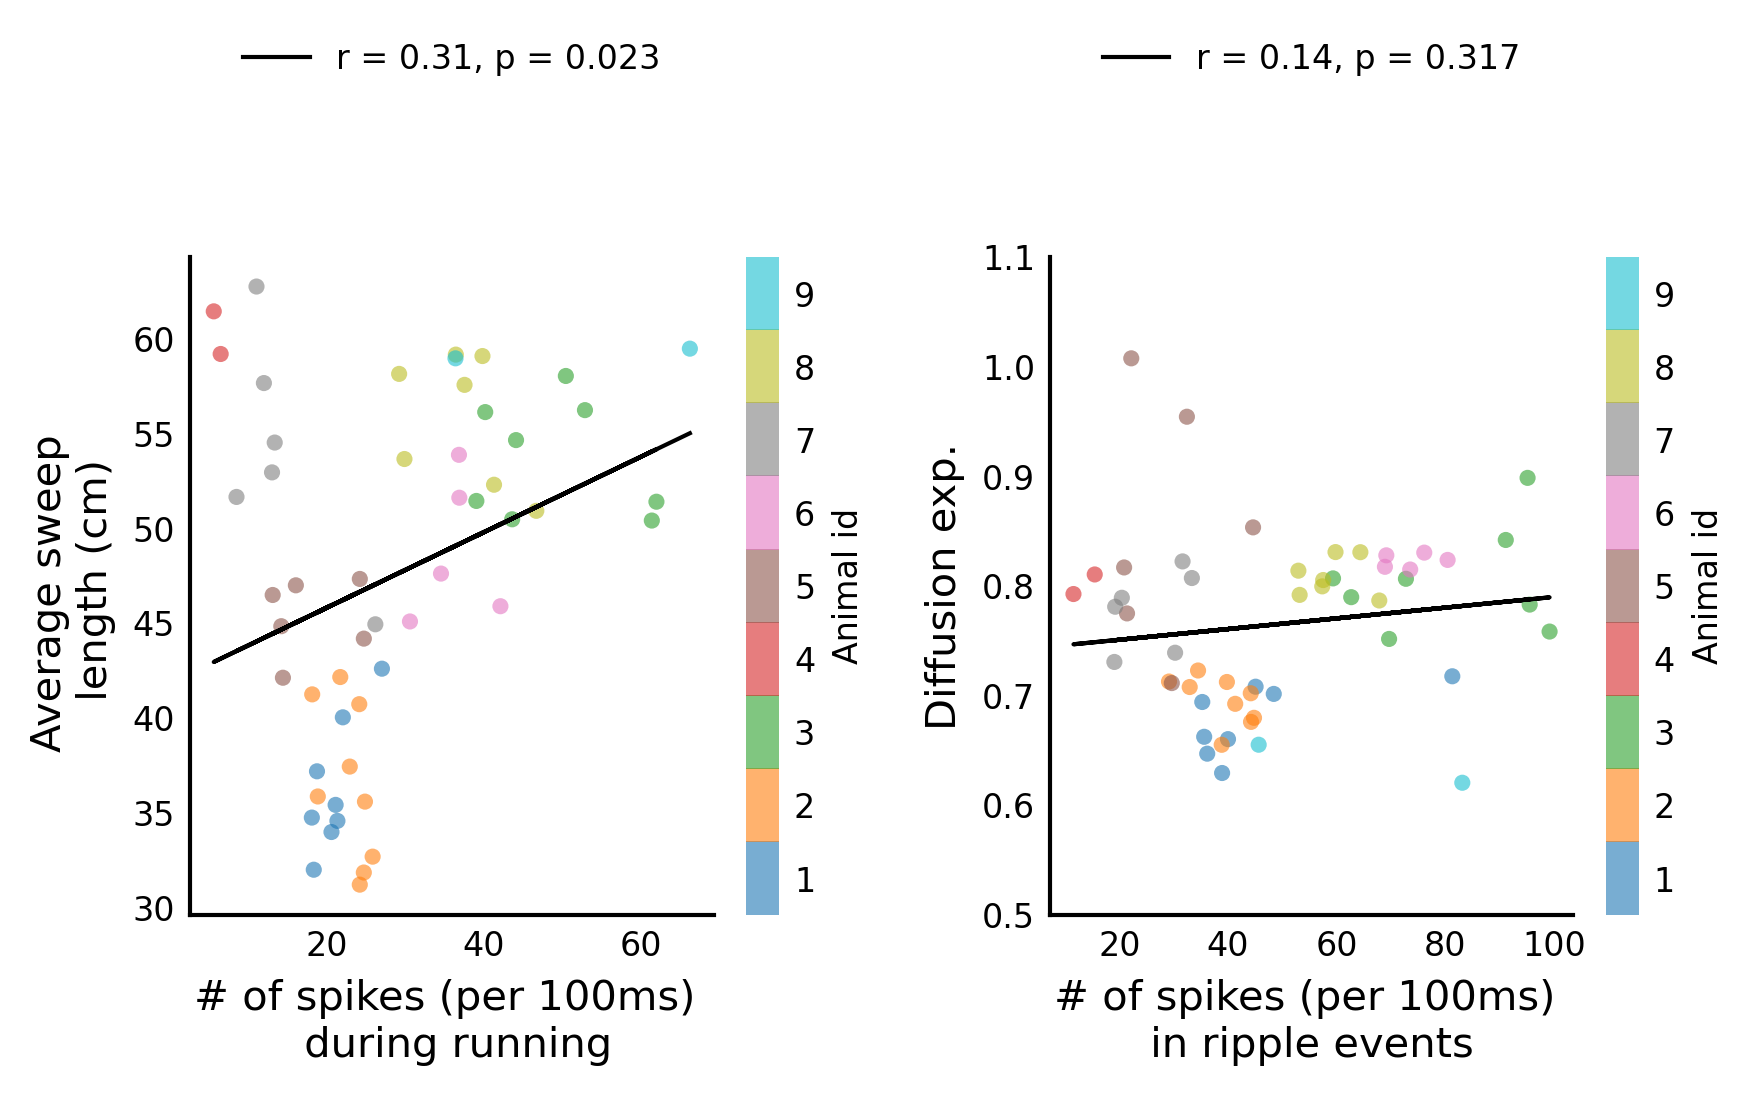

In [9]:
# plot all_exponent_perday_concat_shuffled against all_sweep_len_perday_concat_shuffled
colors = plt.cm.get_cmap("tab10", len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)

# plot the exponent against average active speed, and intercept against average active speed
plt.figure(figsize=(6, 4), dpi=300)
ticksize = 8
labelsize = 10


ax1 = plt.subplot(1, 2, 1)

for name in animal_names:
    plt.scatter(
        np.array(all_running_spikes_perday_concat[name]),
        np.array(all_sweep_amp_perday_concat[name]),
        s=15,
        alpha=0.6,
        color=color_dict[name],
        edgecolors="none",
    )

# add linear fit line to the plot using numpy.polyfit
# convert all_sweep_len_perday_concat_shuffled and all_exponent_perday_concat_shuffled to numpy array
spikes_np = np.concatenate(list(all_running_spikes_perday_concat.values()))
sweep_amp_np = np.concatenate(list(all_sweep_amp_perday_concat.values()))
slope, intercept = np.polyfit(spikes_np, sweep_amp_np, 1)
# pearson test
corr, p = pearsonr(spikes_np, sweep_amp_np)

# if p<0.001, then add label as 'r = %.2f, p < 0.001'; else add label as 'r = %.2f, p = %.3f'
if p < 0.001:
    ax1.plot(
        spikes_np,
        spikes_np * slope + intercept,
        "k-",
        label="r = %.2f, p < 0.001" % (corr),
        linewidth=1,
    )
else:
    ax1.plot(
        spikes_np,
        spikes_np * slope + intercept,
        "k-",
        label="r = %.2f, p = %.3f" % (corr, p),
        linewidth=1,
    )

# legend
ax1.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.3))

# add colorbar with alpha 0.8
cmap = ListedColormap(color_dict.values())
# Create a ScalarMappable with the colormap and normalize it
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(color_dict)))
# Set the colorbar properties
cbar = plt.colorbar(sm, ax=ax1, ticks=list(range(len(color_dict))), alpha=0.6)
# Set colorbar ticks by adding 1 to each tick
ticks = list(range(len(color_dict)))
cbar.set_ticks([tick + 0.5 for tick in ticks])
# set tick labels by adding 1 to each tick
cbar.set_ticklabels(list(range(1, len(color_dict) + 1)))
# Set colorbar ticklabels by adding 1 to each tick
# Set colorbar label
cbar.set_label("Animal id", fontsize=ticksize)
# remove the box of the colorbar
cbar.outline.set_visible(False)
# set cbar tick size, # remove the short ticks in cbar
cbar.ax.tick_params(labelsize=ticksize, length=0)

ax1.set_xlabel("# of spikes (per 100ms) \n during running", fontsize=labelsize)
ax1.set_ylabel("Average sweep \n length (cm)", fontsize=labelsize)


ax2 = plt.subplot(1, 2, 2)


# plot all_exponent_perday_concat_shuffled_crossanimal against all_sweep_len_perday_concat_shuffled_crossanimal
for name in animal_names:
    plt.scatter(
        np.array(all_ripple_spikes_perday_concat[name]),
        np.array(all_exponent_perday_concat[name]),
        s=15,
        alpha=0.6,
        color=color_dict[name],
        edgecolors="none",
    )

# add linear fit line to the plot using numpy.polyfit
# convert all_sweep_len_perday_concat_shuffled_crossanimal and all_exponent_perday_concat_shuffled_crossanimal to numpy array
spikes_np = np.concatenate(list(all_ripple_spikes_perday_concat.values()))
exp_np = np.concatenate(
    list(all_exponent_perday_concat.values())
)
slope, intercept = np.polyfit(spikes_np, exp_np, 1)

# pearson test
corr, p = pearsonr(spikes_np, exp_np)

# if p<0.001, then add label as 'r = %.2f, p < 0.001'; else add label as 'r = %.2f, p = %.3f'
if p < 0.001:
    ax2.plot(
        spikes_np,
        spikes_np * slope + intercept,
        "k-",
        label="r = %.2f, p < 0.001" % (corr),
        linewidth=1,
    )
else:
    ax2.plot(
        spikes_np,
        spikes_np * slope + intercept,
        "k-",
        label="r = %.2f, p = %.3f" % (corr, p),
        linewidth=1,
    )

# legend
ax2.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.3))

# add colorbar with alpha 0.8
cmap = ListedColormap(color_dict.values())
# Create a ScalarMappable with the colormap and normalize it
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(color_dict)))
# Set the colorbar properties
cbar = plt.colorbar(sm, ax=ax2, ticks=list(range(len(color_dict))), alpha=0.6)
# Set colorbar ticks by adding 1 to each tick
ticks = list(range(len(color_dict)))
cbar.set_ticks([tick + 0.5 for tick in ticks])
# set tick labels by adding 1 to each tick
cbar.set_ticklabels(list(range(1, len(color_dict) + 1)))
# Set colorbar ticklabels by adding 1 to each tick
# Set colorbar label
cbar.set_label("Animal id", fontsize=ticksize)
# remove the box of the colorbar
cbar.outline.set_visible(False)
# set cbar tick size, # remove the short ticks in cbar
cbar.ax.tick_params(labelsize=ticksize, length=0)

ax2.set_xlabel("# of spikes (per 100ms) \n in ripple events ", fontsize=labelsize)
ax2.set_ylabel("Diffusion exp.", fontsize=labelsize)
ax2.set_ylim([0.5, 1.1])

for ax in [ax1, ax2]:
    ax.tick_params(labelsize=ticksize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # axis line width 1.0
    ax.spines["bottom"].set_linewidth(1.0)
    ax.spines["left"].set_linewidth(1.0)
    # remove the tick bars on the left and bottom
    ax.tick_params(axis="both", which="both", length=0)

plt.tight_layout()


plt.savefig(
    "../../Processed-Data/Paper_figures/Fig_SI_correlation_with_spike_release.pdf",
    bbox_inches="tight",
    dpi=300,
)